# **Harris Corner Detector Tutorial**

In this notebook we will learn about the Harris Corner Detector. 

1. Harris Corner Detector Intuition
2. Code Algorithm from scratch
3. Use opencv to tune algorithm on real images

## **1. Intuition**

### Corner Detection Intuition

For any pixel in an image, we want to determine if it is a corner or not. We place a window around the center of the pixel, and slide it in different directions such that the pixel is always contained in the window. This pixel is referrd to as the pixel under test. Each time we slide the window, the intensity of all the pixels is summed together. This gives us a notion of change in each direction, let's take a look at the picture below to get a better understanding of what's going on.

![0 wFF0E8ysDtcTpR5q.webp](<attachment:0 wFF0E8ysDtcTpR5q.webp>)
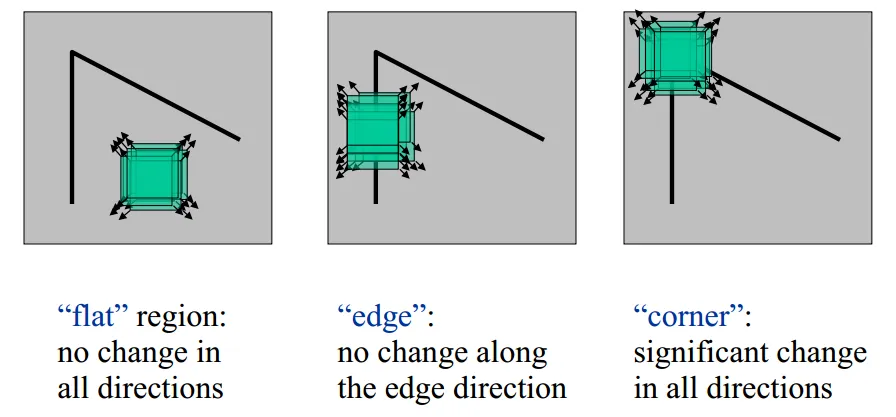

Each time we slide the window in the flat region, we will get roughly the same intensity so, we can determine that there are no edges or corners. If the pixel is on an edge, we could expect that there would be little change as we slide on the direction of the line, but a relatively large change as we slide in the direction against the line. If the pixel is actually a corner, we can expect that we will get a large change in any direction that we slide. We can express this mathemetically as:

![1 0PgiVUqX11wLs9F1JwlLVw.webp](<attachment:1 0PgiVUqX11wLs9F1JwlLVw.webp>)
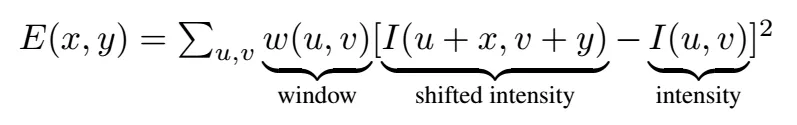

Where we center the pixel at $(u,v)$ and shift is $(x,y)$. For each pixel under test, we can declare a corner if the minimum of all the shifts is greater than some threshold. This is known as Morvec's corner detector and is the basis for the Harris Corner Detector.

### Harris Corner Detector Intuition
The Harris Corner Detector is able to exploit the total variation of the image gradients in order to detect a corner. Let's look at the iamge below to learn more:
<br>


![1 _n-Z_BSBI2--etxB-oRxfA.webp](<attachment:1 _n-Z_BSBI2--etxB-oRxfA.webp>)
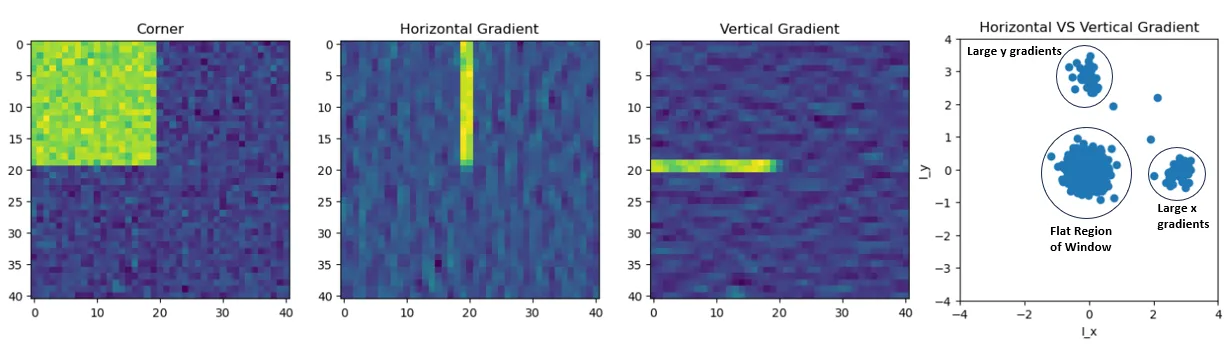

On the left is a test image of a perfect corner with added noise. The middle two images are the x (horizontal) and y (vertical) gradients. On the right is a scatter plot of the x vs y gradients. We can see that the large values in the x and y gradients are caused by the change in intensity of the corner. In the scatter plot, we can see that we have three distinct clusters, flat, x gradient, y gradient; even further we can see that for a corner, there is a large variation between the x and the y gradients. If we assume the x or y gradient to be 0, then we can see that there will only be one direction of large variance, and this single direction of large variance will indicate an edge. e.g. if we only have a vertical gradient, this would mean that we have a horizontal edge. Since the horizontal edge would cause a change in intensity as we traverse the image vertically. Study this image and the one below to convince ypurself that you understand.

![1 PjKUG3GVP_302WIrwp-tOw.webp](<attachment:1 PjKUG3GVP_302WIrwp-tOw.webp>)
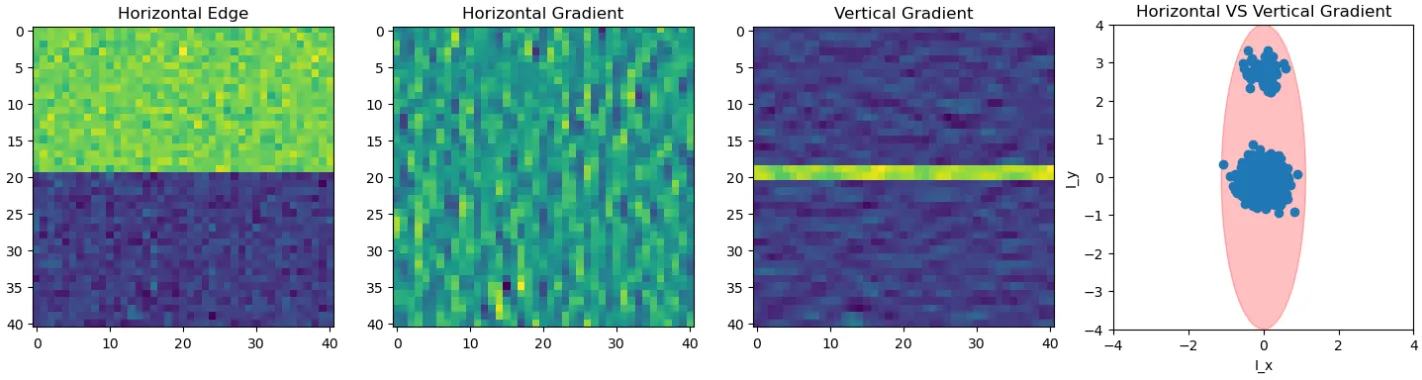

#### How do we efficiently get variation of Gradients?

We have seen how using gradients and their variation with one another will allow us to determine what is a corner or an edge, but how do we get this information? That's what Harris and Stephens figured out, they expanded Morvec's Corner Detector to get an Analytical Expression.

<div>
<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*64Y2ORUCN0sEA6o88Gq6gg.png" width="750"/>
</div>


The resulting expression is in a Quadratic format, and we shape the eigenvalues of the M matrix. The eigenvalues determine the variance in each principle directiion, and the M matrix is comprised of products of image derivatives. So this means that the eigenvalues represent the total variation of image gradients in all directions. And it turns out we can use the eigenvalues to determine if a pixel is a corner, edge, or flat surface.

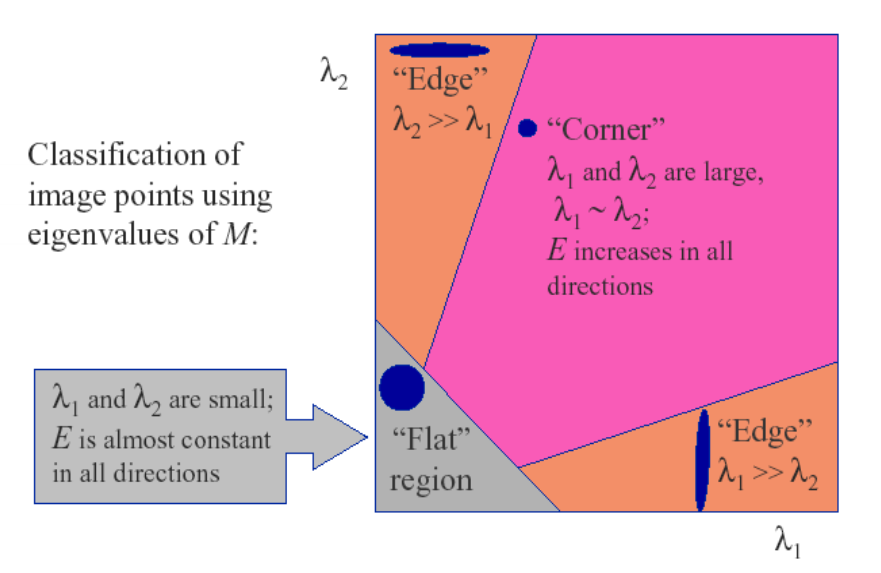
<br>
Source: https://www.cse.psu.edu/~rtc12/CSE486/lecture06.pdf

This should look similar to the gradient intuition above! Computing the eigenvalues is computationally expensive, but thanks to some conveint matrix poperties, we don't have to! Harris and Stephens came up with something called the "Response" R that only involved computing the gradients of the image.

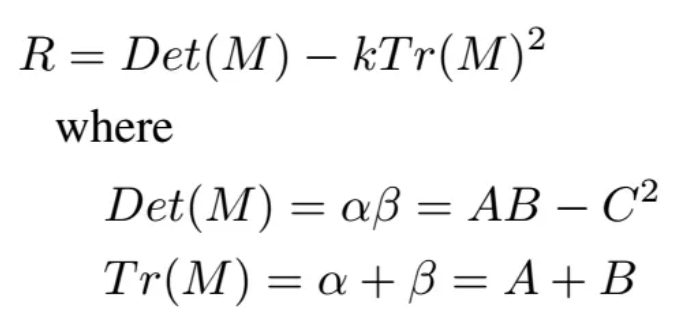

The response R includes a hyperparameter k that will determine how sensitive we are to corners (large k -> less sensitive, small k -> more sensitive). Compare this response with we the classification with image above and convince yourself that you understand the relationship. Now we can write down the full algorithm for Harris Corner Detection

#### Algorithm
1. Compute the horizontal and vertical image derivatives
2. Compute the product of the derivatives (dx*dx, dy*dy, dx*dy)
3. Convolve a Gaussian Smoothing kernel with each of the product derivatives → Any type of blurring should help reduce noise
4. Compute Corner Response: R = (AB — C²) — k (A + B)²
5. Threshold Corner Response to get strong corners: R > thresh

<br>

##### Algorithm Tradeoff!
There is a tradeoff with this algorithm, since it does compute eigenvalue and eigenvectors we don't get to use the information contained in the eigenvectors. The eigenvectors are orthogonal basis vectors that describe the oreintation of the data. In many cases, corners or any good feature to detect, will have rotated eigenvectors since the orientation of their gradients will not likely not be in any standard axis directions. 

This means that we could potentially miss good features to track such as a super corner that could be mistaken for an edge, due to high variation in one direction and low varation in the other direction, but it's eigenvectors would be rotated indicating that it is not just an edge. See test images below along with their scaled eigenvectors of the center pixel.

 <div class="row">
    <img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*chg440eq8ijqeGo1huVtyg.png" width=600/>
    <img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*4UfqPzMJXPaV4vOUKsp0Ug.png" width=600/>
</div> 

Before we code the algorithm, let's see how k impacts the response R

In [234]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

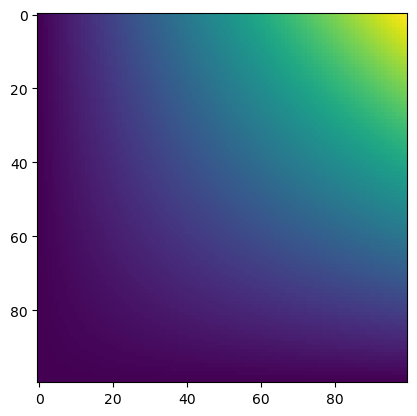

In [236]:
alpha, beta = np.mgrid[0:100, 0:100]/100
alpha = np.flipud(alpha)
k = 1.0e-3 # 1e-5 # change this

R = alpha*beta - k*(alpha - beta)**2
plt.imshow(R);

## **2. Code Algorithm from scratch**

Get Necessary Kernels

In [95]:
# Sobel kernels
Sx = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]])

Sy = Sx.T

# Gaussian Kernel
G = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]])/16

Function to compute corner response

In [237]:
def corner_response(image, k, Sx=Sx, Sy=Sy, G=G):
    # compute first derivatives
    dx = cv2.filter2D(image, ddepth=-1, kernel=Sx)
    dy = cv2.filter2D(image, ddepth=-1, kernel=Sy)

    # Gaussian Filter
    A = cv2.filter2D(dx*dx, ddepth=-1, kernel=G)
    B = cv2.filter2D(dy*dy, ddepth=-1, kernel=G)
    C = cv2.filter2D(dx*dy, ddepth=-1, kernel=G)

    # compute corner response at all pixels
    return (A*B - (C*C)) - k*(A + B)*(A + B)

Get a test image

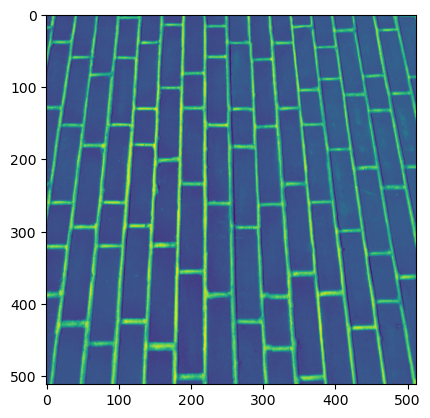

In [238]:
from skimage.data import brick


# get images
image = brick()

# convert to grayscale and normalize
gray = image.copy()/image.max()

plt.imshow(image);

Set hyper parameters

In [239]:
k = 0.05
corner_thresh = 0.075
edge_thresh = -0.05

##### Find the Corners!

In [240]:
# compute corner response
_R = corner_response(gray, k)

# dilate response
R = cv2.dilate(_R, None)

# threshold corners
ret, _corners = cv2.threshold(R, corner_thresh*R.max(), 255, 0)
_corners = np.uint8(_corners)

# (BONUS) threshold edges with undilated response
ret, edges = cv2.threshold(_R, edge_thresh*R.max(), 255, 0)
edges = np.uint8(edges)

## perform non-max supression on corners
# find centroids to decimal accuracy
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(_corners)

# define the criteria to stop and refine the corners subpixel accuracy
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(image, np.float32(centroids), (5,5), (-1,-1), criteria) # need uint8 image

# draw detected corners on the image
image_corners = np.dstack((image, image, image))

for (x, y) in corners:
    x = np.round(x).astype(int)
    y = np.round(y).astype(int)
    cv2.circle(image_corners, (x, y), radius=3, color=(0, 255, 0), thickness=-1)

In [250]:
centroids.shape, corners.shape

((215, 2), (215, 2))

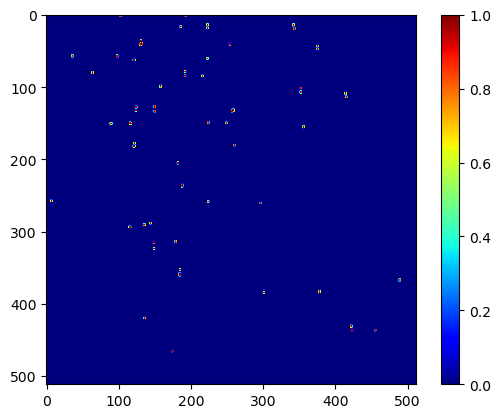

In [244]:
plt.imshow(R > corner_thresh, cmap='jet')
plt.colorbar();

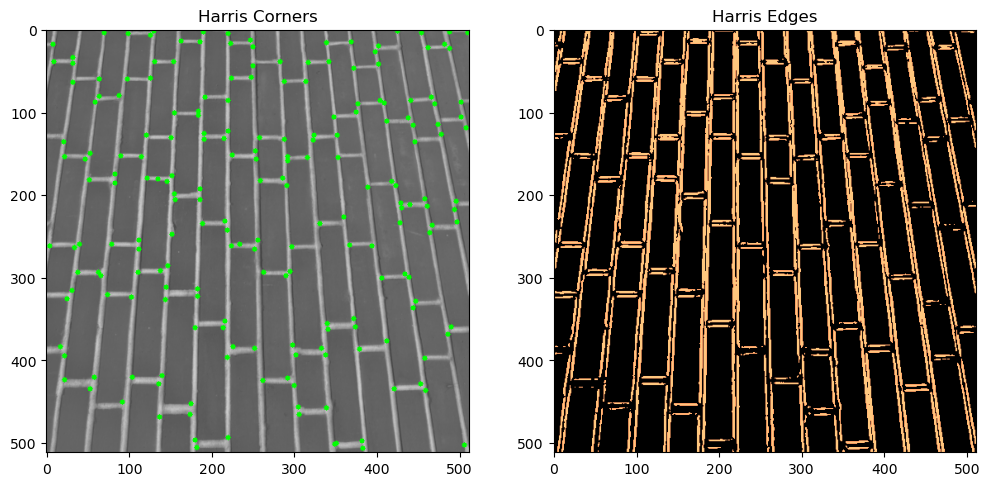

In [233]:
_, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(image_corners)
ax[0].set_title("Harris Corners");
ax[1].imshow(edges, cmap='copper_r')
ax[1].set_title("Harris Edges");

## **3. Use opencv to tune algorithm on real images**

While coding it from scratch help you understand, the opencv library makes things much easier. Let's make an opencv pipeline to find corners on an image!

In [393]:
def harris_corner(image, gray, blockSize, ksize, k, noise=False):
    """ Harris Corner Detection pipeline
        Inputs:
            image - RGB image
            gray - grayscale image
            blockSize - window size for the Gaussian Smoothing (larger values will make the corners less localized)
            ksize - kernel size for the Sobel Operators
            k - hyperparameter for the Harris Corner Response (smaller values allow more features to be detected)
            noise - determines if Gaussian noise is to be added to image
        Outputs:
            corners - array of corners
            image_out - output image with corners drawn
        """
    if noise:
        awgn = np.random.normal(0, 5, size=gray.shape).astype(np.uint8)
    else:
        awgn = 0

    # compute Harris Corner responses
    R = cv2.cornerHarris(gray + awgn, blockSize, ksize, k)

    # dilate
    R = cv2.dilate(R, None)

    # threshold image and convert to uint8
    ret, dst = cv2.threshold(R, 0.05*R.max(), 255, 0)
    dst = np.uint8(dst)

    ## non-maximal supression
    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray, np.float32(centroids), (5,5), (-1,-1), criteria)

    # draw detected corners on the image
    if len(image.shape) > 2:
        image_out = image.copy() + np.dstack((awgn, awgn, awgn))
    else:
        image_out = np.dstack((image, image, image)) + np.dstack((awgn, awgn, awgn))

    for (x, y) in corners:
        x = np.round(x).astype(int)
        y = np.round(y).astype(int)
        cv2.circle(image_out, (x, y), radius=3, color=(0, 255, 0), thickness=-1)

    return corners, image_out

Get more test images

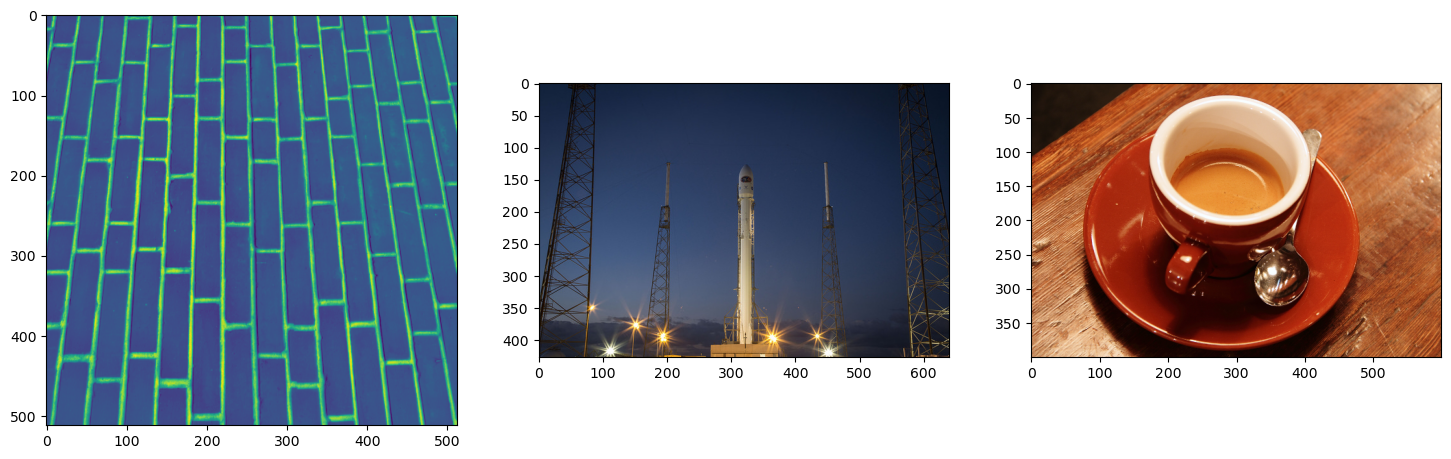

In [394]:
from skimage.data import brick, rocket, coffee


# get images
image_1 = brick()  # tons of good corners
image_2 = rocket() # some good corners
image_3 = coffee() # very few good corners

# convert to grayscale 
gray_1 = image_1.copy() # bricks is already grayscale
gray_2 = cv2.cvtColor(image_2, cv2.COLOR_RGB2GRAY) # .astype(np.float32)
gray_3 = cv2.cvtColor(image_3, cv2.COLOR_RGB2GRAY) # .astype(np.float32)

# display images
_, ax = plt.subplots(1, 3, figsize=(18, 10))
ax[0].imshow(image_1)
ax[1].imshow(image_2)
ax[2].imshow(image_3);

Impact of k

- Large k $\rightarrow$ less sensitive to corners, 
- Small k $\rightarrow$ more sensitive to corners

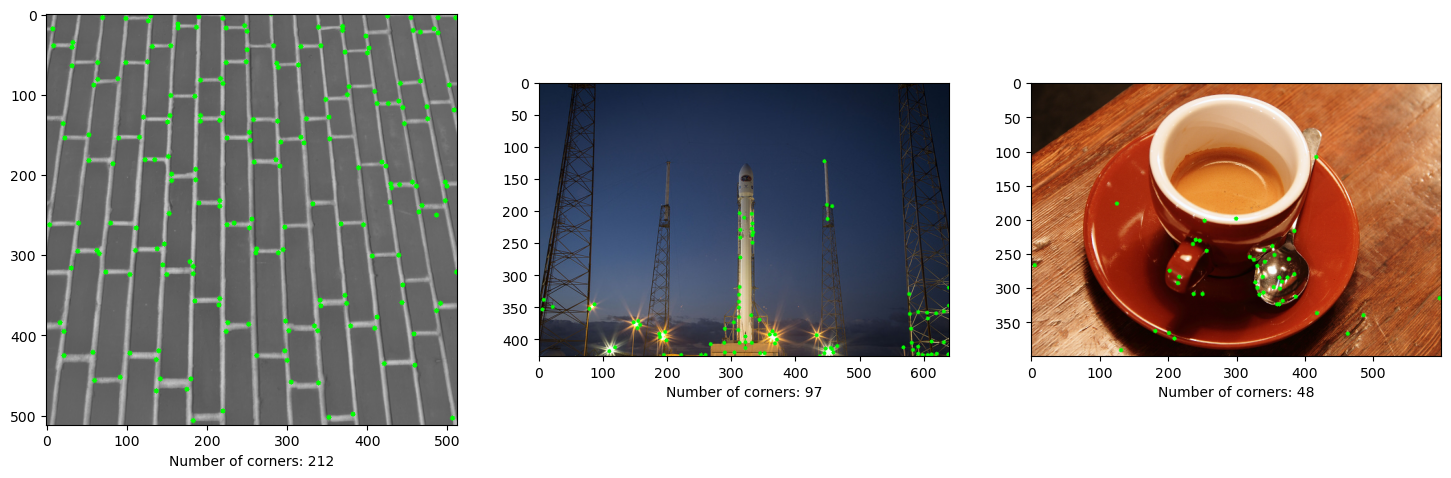

In [406]:
corners_1, image_out_1 = harris_corner(image_1, gray_1, blockSize=2, ksize=3, k=0.05, noise=False) # 
corners_2, image_out_2 = harris_corner(image_2, gray_2, blockSize=2, ksize=3, k=0.025, noise=False) # 
corners_3, image_out_3 = harris_corner(image_3, gray_3, blockSize=2, ksize=3, k=0.15, noise=False) # 

_, ax = plt.subplots(1, 3, figsize=(18, 10))
ax[0].imshow(image_out_1)
ax[0].set_xlabel(f"Number of corners: {len(corners_1)}")
ax[1].imshow(image_out_2)
ax[1].set_xlabel(f"Number of corners: {len(corners_2)}")
ax[2].imshow(image_out_3)
ax[2].set_xlabel(f"Number of corners: {len(corners_3)}");

Impact of Sobel Kernel size

- Sobel Kernels are used to compute the image gradients
- Must be 1, 3, 5, or 7
- A large kernel will distill gradient information from a large area and reduce the number of detected corners
- A small kernel will provide more localized gradient information and increase the number of detected corners

scale:  8


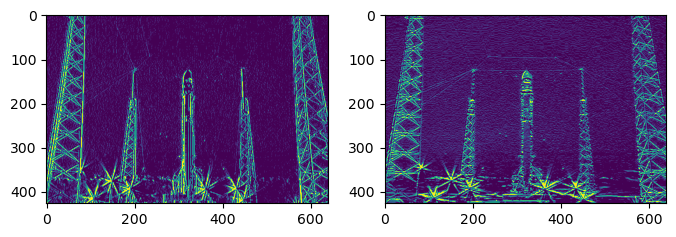

In [413]:
ksize = 3
scale = (1 << (ksize - 1)) * 2
print('scale: ', scale)

grad_x = cv2.Sobel(gray_2, -1, 1, 0, ksize=ksize, scale=scale, delta=0, borderType=cv2.BORDER_DEFAULT)
grad_y = cv2.Sobel(gray_2, -1, 0, 1, ksize=ksize, scale=scale, delta=0, borderType=cv2.BORDER_DEFAULT)

_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(grad_x)
ax[1].imshow(grad_y);

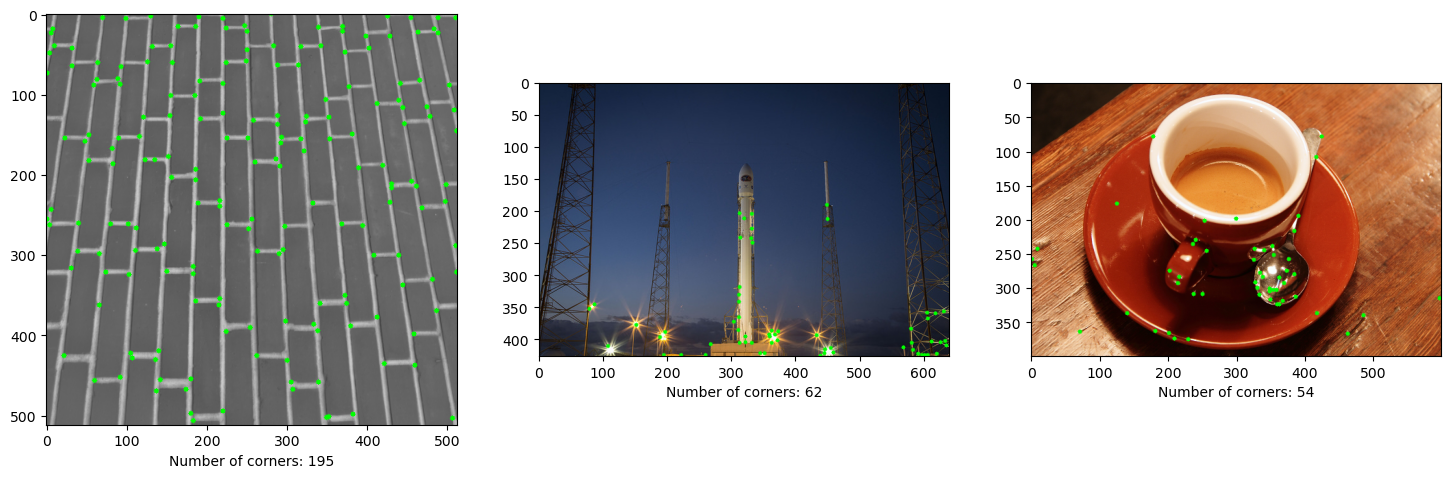

In [418]:
corners_1, image_out_1 = harris_corner(image_1, gray_1, blockSize=2, ksize=5, k=0.05, noise=False) # 
corners_2, image_out_2 = harris_corner(image_2, gray_2, blockSize=2, ksize=5, k=0.05, noise=False) # 
corners_3, image_out_3 = harris_corner(image_3, gray_3, blockSize=2, ksize=5, k=0.05, noise=False) # 

_, ax = plt.subplots(1, 3, figsize=(18, 10))
ax[0].imshow(image_out_1)
ax[0].set_xlabel(f"Number of corners: {len(corners_1)}")
ax[1].imshow(image_out_2)
ax[1].set_xlabel(f"Number of corners: {len(corners_2)}")
ax[2].imshow(image_out_3)
ax[2].set_xlabel(f"Number of corners: {len(corners_3)}");

Imact of Block Size

- Reduces noise
- Larger values will make the corners less localized

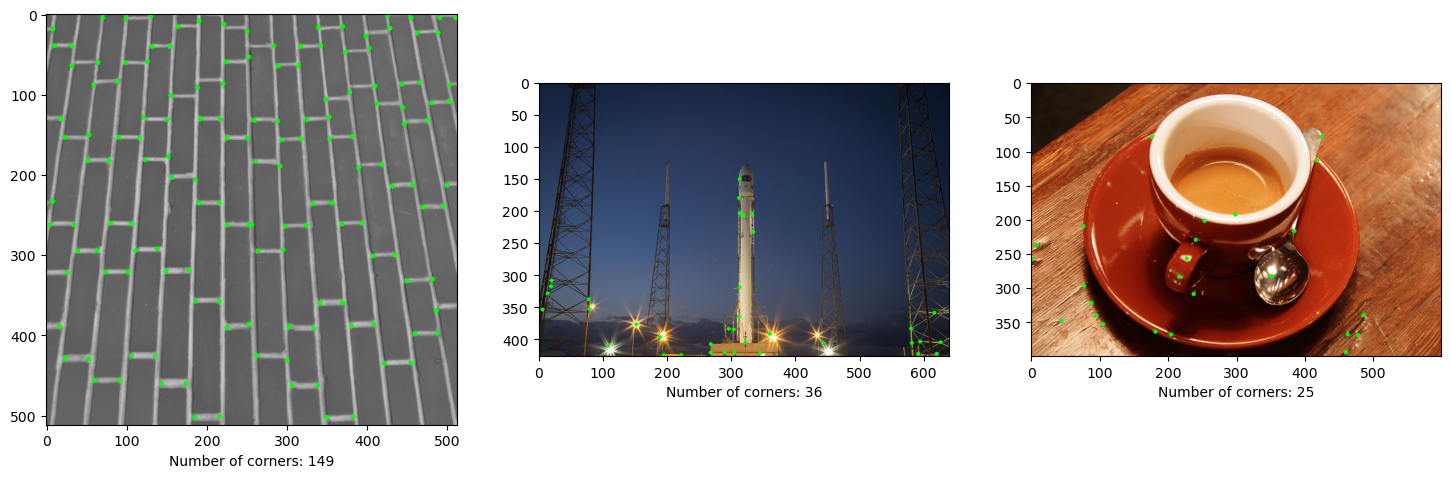

In [421]:
corners_1, image_out_1 = harris_corner(image_1, gray_1, blockSize=12, ksize=3, k=0.05, noise=False) # large blocksize is meant to reduce noise!
corners_2, image_out_2 = harris_corner(image_2, gray_2, blockSize=12, ksize=3, k=0.05, noise=False) # 
corners_3, image_out_3 = harris_corner(image_3, gray_3, blockSize=12, ksize=3, k=0.05, noise=False) # 

_, ax = plt.subplots(1, 3, figsize=(18, 10))
ax[0].imshow(image_out_1)
ax[0].set_xlabel(f"Number of corners: {len(corners_1)}")
ax[1].imshow(image_out_2)
ax[1].set_xlabel(f"Number of corners: {len(corners_2)}")
ax[2].imshow(image_out_3)
ax[2].set_xlabel(f"Number of corners: {len(corners_3)}");

Impact of Noise

Note the noise is rolling over in uint8, causing light splotches in dark areas

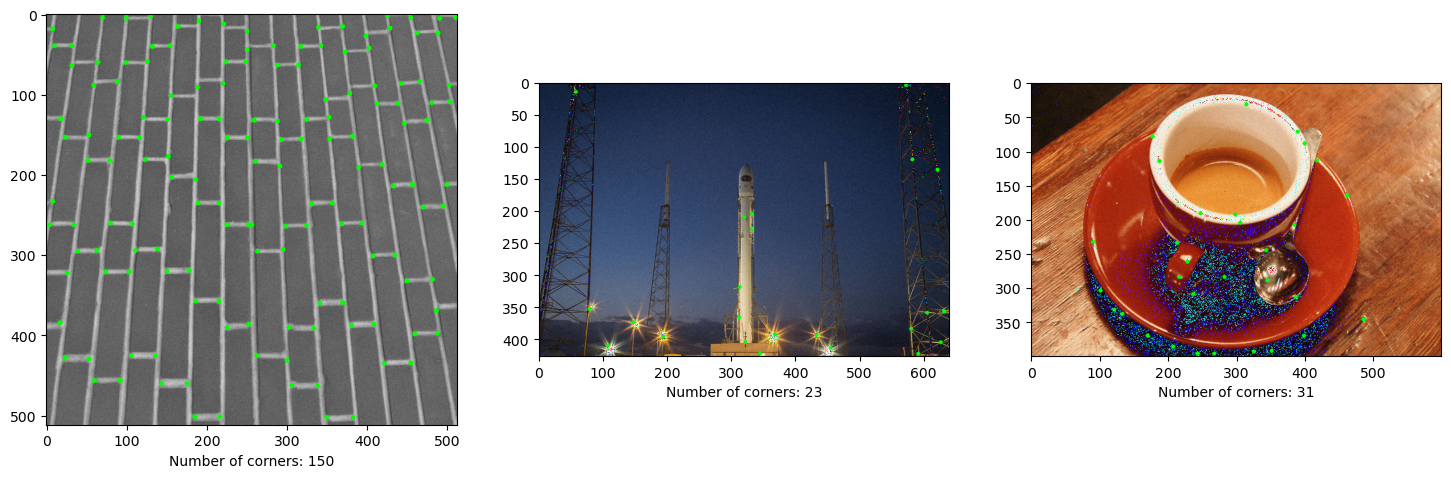

In [428]:
corners_1, image_out_1 = harris_corner(image_1, gray_1, blockSize=12, ksize=3, k=0.05, noise=True) # change the blocksize (large blocksize is meant to reduce noise!)
corners_2, image_out_2 = harris_corner(image_2, gray_2, blockSize=12, ksize=3, k=0.05, noise=True) # see what changing the noise does
corners_3, image_out_3 = harris_corner(image_3, gray_3, blockSize=12, ksize=3, k=0.05, noise=True) # use large blocksize to get larger features

_, ax = plt.subplots(1, 3, figsize=(18, 10))
ax[0].imshow(image_out_1)
ax[0].set_xlabel(f"Number of corners: {len(corners_1)}")
ax[1].imshow(image_out_2)
ax[1].set_xlabel(f"Number of corners: {len(corners_2)}")
ax[2].imshow(image_out_3)
ax[2].set_xlabel(f"Number of corners: {len(corners_3)}");